<a href="https://colab.research.google.com/github/vahid-am/Vahid-am.github.io/blob/main/GAN_vs_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

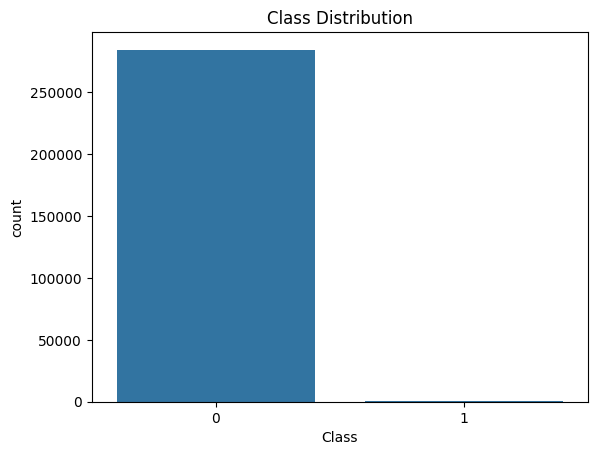

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


New Class Distribution after SMOTE:
Class
0    199020
1    199020
Name: count, dtype: int64


In [7]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from imblearn.over_sampling import RandomOverSampler
#from utils import GANDataBalancer



# Load Dataset
df = pd.read_csv('creditcard.csv')

# Basic EDA
print(df.head())
print(df.info())
print(df.describe())

# Check for missing values
print("Missing values:", df.isnull().sum().sum())

# Checking class distribution
print("Class distribution:")
print(df['Class'].value_counts())

# Plot the class distribution
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()



# Define the GAN-based Data Balancer class
class GANDataBalancer:
    def __init__(self, sampling_strategy=0.05, random_state=42, latent_dim=100):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.latent_dim = latent_dim

    def build_generator(self, output_dim):
        model = Sequential([
            Input(shape=(self.latent_dim,)),  # Define input shape explicitly
            Dense(32, activation='relu'),
            Dense(64, activation='relu'),
            Dense(output_dim, activation='linear')
        ])
        return model

    def build_discriminator(self, input_dim):
        model = Sequential([
            Input(shape=(input_dim,)),  # Define input shape explicitly
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',  # Ensure optimizer is set
            loss='binary_crossentropy',  # Ensure loss function is defined
            metrics=['accuracy']  # Metrics for debugging
        )
        return model

    def build_gan(self):
        self.discriminator.trainable = False
        gan_input = Input(shape=(self.latent_dim,))
        x = self.generator(gan_input)
        gan_output = self.discriminator(x)
        gan = Model(gan_input, gan_output)
        gan.compile(
            optimizer='adam',  # Set optimizer
            loss='binary_crossentropy'  # Set loss function
        )
        return gan

    def fit(self, X, y, epochs=10000, batch_size=64):
        # Convert X and y to DataFrame and Series respectively for consistency
        X = pd.DataFrame(X)
        y = pd.Series(y).reset_index(drop=True)

        # Split data into majority and minority classes
        X_minority = X[y == 1]
        X_majority = X[y == 0]
        self.resample_number = int(self.sampling_strategy * len(X_majority) - len(X_minority))

        # Save column names
        self.X_columns = X.columns
        minority_class_samples = X_minority.values

        # Initialize models
        self.generator = self.build_generator(X.shape[1])
        self.discriminator = self.build_discriminator(X.shape[1])
        self.gan = self.build_gan()

        for epoch in range(epochs):
            # Train Discriminator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            fake_data = self.generator.predict(noise)
            real_data = minority_class_samples[
                np.random.randint(0, minority_class_samples.shape[0], size=batch_size)
            ]
            X_combined = np.vstack((real_data, fake_data))
            y_combined = np.hstack((np.ones(batch_size), np.zeros(batch_size)))

            # Ensure the discriminator is trainable before training
            self.discriminator.trainable = True
            d_loss = self.discriminator.train_on_batch(X_combined, y_combined)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            y_gen = np.ones(batch_size)  # Generator tries to fool discriminator
            self.discriminator.trainable = False  # Freeze discriminator
            g_loss = self.gan.train_on_batch(noise, y_gen)

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}/{epochs} | Discriminator Loss: {d_loss} | Generator Loss: {g_loss}")

    def resample(self, X, y):
        synthetic_data = self.generator.predict(
            np.random.normal(0, 1, (self.resample_number, self.latent_dim))
        )
        synthetic_df = pd.DataFrame(synthetic_data, columns=self.X_columns)
        balanced_X = pd.concat([pd.DataFrame(X, columns=self.X_columns), synthetic_df], ignore_index=True)
        balanced_y = pd.concat([pd.Series(y), pd.Series([1] * synthetic_df.shape[0])], ignore_index=True)
        return balanced_X, balanced_y

    def fit_resample(self, X, y, epochs=1000, batch_size=64):
        self.fit(X, y, epochs=epochs, batch_size=batch_size)
        return self.resample(X, y)



# Feature-Label Separation
target = "Class"
df = df.dropna(subset=[target])
X = df.drop(columns=[target])
y = df[target]


# Data Normalization (most features are already scaled)
scaler = StandardScaler()
X = scaler.fit_transform(X)


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Handle Imbalanced Data using SMOTE
smote = SMOTE(random_state=42)
# Handle Imbalanced Data using GAN
#smote = GANDataBalancer(sampling_strategy=1.0, random_state=42, latent_dim=100)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution after SMOTE
print("New Class Distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Model1: Logistic Regression (LR)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443



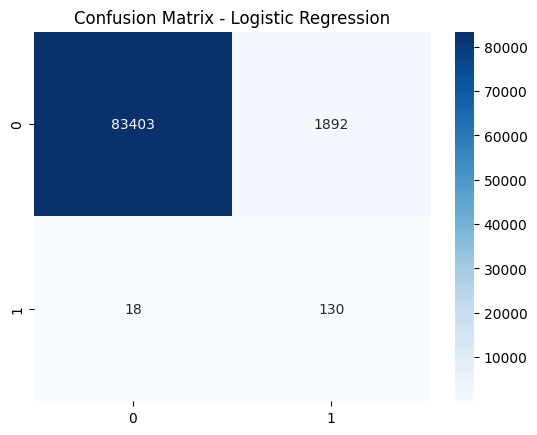

Logistic Regression ROC-AUC: 0.9670
Precision-LR: 0.06
Recall-LR: 0.88
F1 Score-LR: 0.12
Accuracy-LR:
0.9776459159907774


In [8]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation for Logistic Regression
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Confusion Matrix
conf_matrix_log = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC-AUC for Logistic Regression
log_reg_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Logistic Regression ROC-AUC: {log_reg_auc:.4f}")

precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)
accuracy_log_reg=accuracy_score(y_test, y_pred_log_reg)

print(f"Precision-LR: {precision_log_reg:.2f}")
print(f"Recall-LR: {recall_log_reg:.2f}")
print(f"F1 Score-LR: {f1_log_reg:.2f}")
print("Accuracy-LR:")
print(accuracy_log_reg)

# Model2: XGBoost Classifier (XGB)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.74      0.80      0.77       148

    accuracy                           1.00     85443
   macro avg       0.87      0.90      0.89     85443
weighted avg       1.00      1.00      1.00     85443



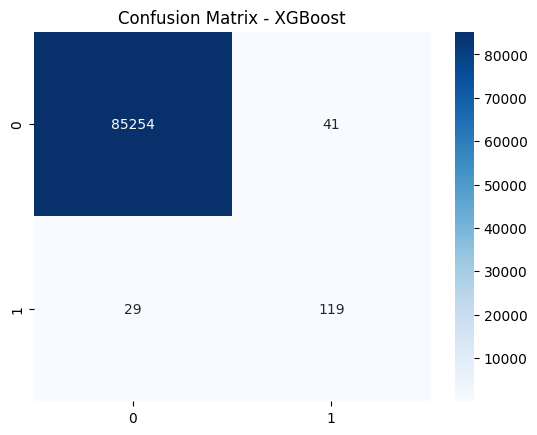

XGBoost ROC-AUC: 0.9738
Precision-XGB: 0.74
Recall-XGB: 0.80
F1 Score-XGB: 0.77
Accuracy-XGB:
0.9991807403766253


In [9]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=1)  # Adjust scale_pos_weight based on imbalance
xgb.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation for XGBoost
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC-AUC for XGBoost
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
print(f"XGBoost ROC-AUC: {xgb_auc:.4f}")

precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
accuracy_xgb=accuracy_score(y_test, y_pred_xgb)

print(f"Precision-XGB: {precision_xgb:.2f}")
print(f"Recall-XGB: {recall_xgb:.2f}")
print(f"F1 Score-XGB: {f1_xgb:.2f}")
print("Accuracy-XGB:")
print(accuracy_xgb)

# Model3: Support Vector Classifier (SVC)

In [ ]:
csvc = SVC(kernel='linear', class_weight='balanced', random_state=42)
csvc.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation for SVC
y_pred_csvc = csvc.predict(X_test)
print("Support Vector Classification Report:")
print(classification_report(y_test, y_pred_csvc))

# Confusion Matrixm
conf_matrix_csvc = confusion_matrix(y_test, y_pred_csvc)
plt.show()

# ROC-AUC for SVC
csvc_auc = roc_auc_score(y_test, csvc.predict_proba(X_test)[:, 1])
print(f"SVC ROC-AUC: {csvc_auc:.4f}")

precision_csvc = precision_score(y_test, y_pred_csvc)
recall_csvc = recall_score(y_test, y_pred_csvc)
f1_csvc = f1_score(y_test, y_pred_csvc)
accuracy_csvc=accuracy_score(y_test, y_pred_csvc)

print(f"Precision-SVC: {precision_csvc:.2f}")
print(f"Recall-SVC: {recall_csvc:.2f}")
print(f"F1 Score-SVC: {f1_csvc:.2f}")
print("Accuracy-SVC:")
print(accuracy_csvc)

# Model4: Random Forest  Classifie (RF)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



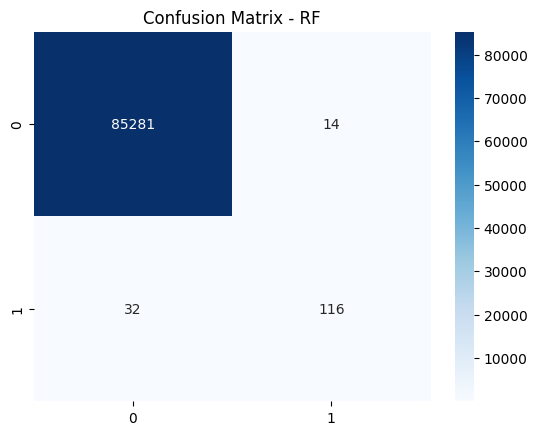

RF ROC-AUC: 0.9625
Precision-RF: 0.89
Recall-RF: 0.78
F1 Score-RF: 0.83
Accuracy-RF:
0.9994616293903538


In [10]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_smote, y_train_smote)

# Predictions and Evaluation for XGBoost
y_pred_rfc = rfc.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rfc))

# Confusion Matrix
conf_matrix_rfc = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(conf_matrix_rfc, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - RF")
plt.show()

# ROC-AUC for XGBoost
rfc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print(f"RF ROC-AUC: {rfc_auc:.4f}")

precision_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_rfc= f1_score(y_test, y_pred_rfc)
accuracy_rfc=accuracy_score(y_test, y_pred_rfc)

print(f"Precision-RF: {precision_rfc:.2f}")
print(f"Recall-RF: {recall_rfc:.2f}")
print(f"F1 Score-RF: {f1_rfc:.2f}")
print("Accuracy-RF:")
print(accuracy_rfc)

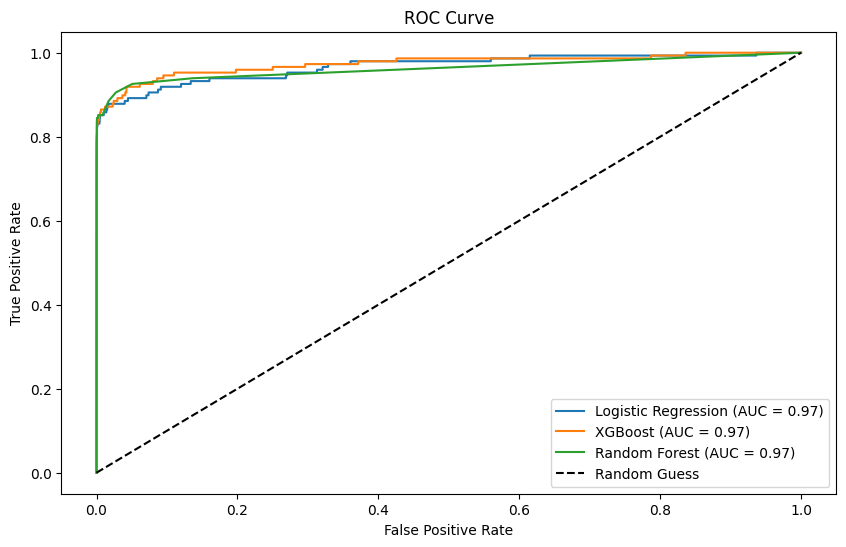

In [11]:
fpr_log, tpr_log, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb.predict_proba(X_test)[:, 1])
#fpr_csvc, tpr_csvc, _ = roc_curve(y_test, csvc.predict_proba(X_test)[:, 1])
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, rfc.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.2f})')
#plt.plot(fpr_csvc, tpr_csvc, label=f'SVC (AUC = {csvc_auc:.2f})')
plt.plot(fpr_rfc, tpr_rfc, label=f'Random Forest (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()